![Fixel Algorithms](https://fixelalgorithms.co/images/CCExt.png)

# <center> Machine Learning Methods </center>
## <center> Lecture 28 - PyTorch</center>
### <center> Cifar-10 and Regression Exercise</center>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/FixelAlgorithmsTeam/FixelCourses/blob/master/MachineLearningMethod/28_PyTorch/MainPyTorchCifar.ipynb)

In [1]:
#-- Wide screen:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
#-- Auto reload:
%load_ext autoreload
%autoreload 2

In [3]:
#-- Imports:
import numpy             as np
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rc('font', **{'size' : 16})

#-- torch:
import torch

#-- Fix seed (for presentation sake)
torch.manual_seed(0)
np.random.seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark     = False

### Train & validation loops:


In [4]:
#-- Classification accuracy:
def Accuracy(mHatY, vY):
    vHatY = mHatY.argmax(dim=1)
    return (vHatY == vY).float().mean().item()

#### Train loop:

In [5]:
def TrainLoop(oModel, oTrainDL, LossFunc, oOptim):

    epochLoss = 0
    epochAcc  = 0
    count     = 0                                #-- number of samples
    device    = next(oModel.parameters()).device #-- CPU\GPU
    oModel.train(True)
    
    #-- Iterate over the mini-batches:
    for ii, (mX, vY) in enumerate(oTrainDL):
        #-- Move to device (CPU\GPU):
        mX = mX.to(device)
        vY = vY.to(device)
        
        #-- Set gradients to zeros:
        oOptim.zero_grad()
        
        #-- Forward:
        mHatY = oModel(mX)
        loss  = LossFunc(mHatY, vY)

        #-- Backward:
        loss.backward()

        #-- Parameters update:
        oOptim.step()
        
        print(f'\rIteration: {ii:3d}: loss = {loss:.6f}', end='')
        #-- Accumulate loss:
        Nb         = mX.shape[0]
        epochLoss += Nb * loss.item()
        epochAcc  += Nb * Accuracy(mHatY, vY)
        count     += Nb

    print('', end='\r')
    epochLoss /= count
    epochAcc  /= count

    return epochLoss, epochAcc

#### Validation loop:

In [6]:
def ValidationLoop(oModel, oValDL, LossFunc):

    if oValDL is None:
        return 0, 0
    
    epochLoss = 0
    epochAcc  = 0
    count     = 0                                #-- number of samples
    device    = next(oModel.parameters()).device #-- CPU\GPU
    oModel.train(False)
    
    #-- Iterate over the mini-batches:
    with torch.no_grad():
        for ii, (mX, vY) in enumerate(oValDL):
            #-- Move to device (CPU\GPU):
            mX = mX.to(device)
            vY = vY.to(device)
            
            #-- Forward:
            mHatY = oModel(mX)
            loss  = LossFunc(mHatY, vY)

            Nb         = len(vY)
            epochLoss += Nb * loss.item()
            epochAcc  += Nb * Accuracy(mHatY, vY)
            count     += Nb

    epochLoss /= count
    epochAcc  /= count

    return epochLoss, epochAcc

#### Train model:

In [7]:
import time

def TrainModel(oModel, oTrainDL, oValDL, LossFunc, numEpochs, oOptim):

    bestAcc = 0
    for epoch in range(numEpochs):
        
        startTime           = time.time()
        trainLoss, trainAcc = TrainLoop(oModel, oTrainDL, LossFunc, oOptim) #-- train
        valLoss,   valAcc   = ValidationLoop(oModel, oValDL, LossFunc)      #-- validation
        
        endTime = time.time()
        print('Epoch '              f'{epoch:3d}:',                  end='')
        print(' | Train loss: '     f'{trainLoss:.5f}',              end='')
        print(' | Val loss: '       f'{valLoss:.5f}',                end='')
        print(' | Train Accuracy: ' f'{trainAcc:2.4f}',              end='')
        print(' | Val Accuracy: '   f'{valAcc:2.4f}',                end='')
        print(' | epoch time: '     f'{(endTime-startTime):8.3f} |', end='')
        
        #-- Save best model:
        if valAcc > bestAcc:
            bestAcc   = valAcc
            try:
                torch.save(oModel.state_dict(), 'BestModelParameters.pt')
            except:
                pass
            print(' <-- Checkpoint!')
        else:
            print()

    #-- Return best model:
    oModel.load_state_dict(torch.load('BestModelParameters.pt'))

### Download CIFAR-10 dataset:

In [8]:
import torchvision
import torchvision.transforms as transforms

oTrainSet = torchvision.datasets.CIFAR10(root='../../data', train=True,  download=True, transform=transforms.ToTensor())
oTestSet  = torchvision.datasets.CIFAR10(root='../../data', train=False, download=True, transform=transforms.ToTensor())

oTrainSet.data.shape, oTrainSet[0][0].shape

Files already downloaded and verified
Files already downloaded and verified


((50000, 32, 32, 3), torch.Size([3, 32, 32]))

In [9]:
lClasses  = oTrainSet.classes
lClasses

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

### Plot some examples:

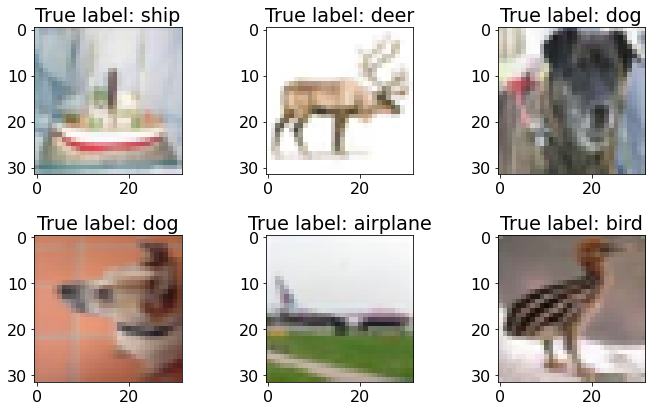

In [10]:
N, H, W, C = oTrainSet.data.shape
fig, _     = plt.subplots(2, 3, figsize=(10,6))
for ax in fig.axes:
    idx   = np.random.randint(N)
    mX, y = oTrainSet[idx]
    ax.imshow(np.transpose(mX.numpy(), (1,2,0)), cmap='gray')
    ax.set_title('True label: ' + str(lClasses[y]))
    
plt.tight_layout()
plt.show()

### Compute mean and variance:

In [11]:
vMean = oTrainSet.data.mean((0,1,2)) / 255
vStd  = oTrainSet.data.std ((0,1,2)) / 255
print('µ =', vMean)
print('σ =', vStd)

µ = [0.49139968 0.48215841 0.44653091]
σ = [0.24703223 0.24348513 0.26158784]


### Add normalization to the datasets:

In [12]:
oTransform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(vMean, vStd)
])

oTrainSet.transform = oTransform
oTestSet. transform = oTransform

### Create data loaders:

In [13]:
batchSize = 128
oTrainDL  = torch.utils.data.DataLoader(oTrainSet, shuffle=True,  batch_size=batchSize,   num_workers=2)
oTestDL   = torch.utils.data.DataLoader(oTestSet,  shuffle=False, batch_size=2*batchSize, num_workers=2)

### Define the model (architecture):

In [14]:
import torch.nn            as nn
import torch.nn.functional as F
import torch.optim         as optim
import torchsummary

#-- Tensor to vector (reshape):
class Flatten(nn.Module):
    def forward(self, mX):
        N  = mX.shape[0]
        mZ = mX.view(N, -1)
        return mZ

#--------------------------------------------------------------------------------#
#--------------------------------------------------------------------------------#
#-- Model:
def GetModel():
    oModel = nn.Sequential(
        nn.Sequential(), #-- does nothing
        Flatten(),
        nn.Linear(3*32*32, 500), nn.ReLU(),
        nn.Linear(500,     250), nn.ReLU(),
        nn.Linear(250,      10)
    )
    return oModel

#--------------------------------------------------------------------------------#
#--------------------------------------------------------------------------------#
torchsummary.summary(GetModel(), (3, H, W), device='cpu'); print()

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 3, 32, 32]           --
├─Flatten: 1-2                           [-1, 3072]                --
├─Linear: 1-3                            [-1, 500]                 1,536,500
├─ReLU: 1-4                              [-1, 500]                 --
├─Linear: 1-5                            [-1, 250]                 125,250
├─ReLU: 1-6                              [-1, 250]                 --
├─Linear: 1-7                            [-1, 10]                  2,510
Total params: 1,664,260
Trainable params: 1,664,260
Non-trainable params: 0
Total mult-adds (M): 1.66
Input size (MB): 0.01
Forward/backward pass size (MB): 0.01
Params size (MB): 6.35
Estimated Total Size (MB): 6.37



#### Set cross-entropy loss:

In [15]:
LossFunc = nn.CrossEntropyLoss()

### Check whether GPU is available:

In [16]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
device

device(type='cuda', index=0)

### Train the model:

In [17]:
oModel    = GetModel().to(device)
oOptim    = optim.AdamW(oModel.parameters(), lr=1e-4, betas=(0.9, 0.99), weight_decay=1e-4)
numEpochs = 20

TrainModel(oModel, oTrainDL, oTestDL, LossFunc, numEpochs, oOptim)

Epoch   0: | Train loss: 1.70577 | Val loss: 1.53966 | Train Accuracy: 0.4008 | Val Accuracy: 0.4686 | epoch time:   10.608 | <-- Checkpoint!
Epoch   1: | Train loss: 1.48256 | Val loss: 1.45639 | Train Accuracy: 0.4811 | Val Accuracy: 0.4871 | epoch time:   11.602 | <-- Checkpoint!
Epoch   2: | Train loss: 1.37918 | Val loss: 1.40531 | Train Accuracy: 0.5201 | Val Accuracy: 0.5045 | epoch time:   10.260 | <-- Checkpoint!
Epoch   3: | Train loss: 1.30310 | Val loss: 1.37140 | Train Accuracy: 0.5490 | Val Accuracy: 0.5201 | epoch time:   10.045 | <-- Checkpoint!
Epoch   4: | Train loss: 1.24127 | Val loss: 1.35288 | Train Accuracy: 0.5714 | Val Accuracy: 0.5297 | epoch time:    9.989 | <-- Checkpoint!
Epoch   5: | Train loss: 1.18667 | Val loss: 1.33525 | Train Accuracy: 0.5920 | Val Accuracy: 0.5324 | epoch time:    9.903 | <-- Checkpoint!
Epoch   6: | Train loss: 1.13517 | Val loss: 1.32282 | Train Accuracy: 0.6122 | Val Accuracy: 0.5382 | epoch time:   10.021 | <-- Checkpoint!
Epoch 

### Regression exercise:
* Use the California housing dataset `fetch_california_housing`.
* Use MSE loss (instead of the cross-entropy)
* Replace the classification accuracy with $R^2$ score.
* Try to get the best MSE\R2 score you can.

**Tips**:
* You should test different models (layers\activations) and hyper-parameters.
* Try different optimizers and regularizations.
* $R_2 > 0.85$ (on the validation set) is quite good.

In [18]:
from sklearn.datasets import fetch_california_housing

mX, vY  = fetch_california_housing(return_X_y=True)
mX     -= np.mean(mX, axis=0)
mX     /= np.std (mX, axis=0)

mX.shape, vY.shape

((20640, 8), (20640,))

In [19]:
from sklearn.model_selection import train_test_split

Ntrain  = 15000
Ntest   = 5640
vIdx    = np.random.choice(Ntrain + Ntest, Ntrain + Ntest)
mX      = mX[vIdx,:]
vY      = vY[vIdx]

mTrainX, mTestX, vTrainY, vTestY = train_test_split(mX, vY, train_size=Ntrain, test_size=Ntest)

(mTrainX.shape, 
vTrainY.shape, 
mTestX.shape,  
vTestY.shape)

((15000, 8), (15000,), (5640, 8), (5640,))

In [20]:
from torch.utils.data import TensorDataset

oTrainSet = TensorDataset(torch.tensor(mTrainX, dtype=torch.float32), torch.tensor(vTrainY, dtype=torch.float32))
oTestSet  = TensorDataset(torch.tensor(mTestX,  dtype=torch.float32), torch.tensor(vTestY,  dtype=torch.float32))

In [21]:
from sklearn.metrics import r2_score

def R2Score(vY, vHatY):
    vY    = vY.detach().cpu()
    vHatY = vHatY.detach().cpu()
    return r2_score(???, ???)

SyntaxError: invalid syntax (<ipython-input-21-6842a6d38f10>, line 6)

In [ ]:
def TrainLoop(oModel, oTrainDL, LossFunc, oOptim):

    epochLoss = 0
    epochR2   = 0
    count     = 0                                #-- number of samples
    device    = next(oModel.parameters()).device #-- CPU\GPU
    oModel.train(True)
        
    #-- Iterate over the mini-batches:
    for ii, (mX, vY) in enumerate(oTrainDL):
        #-- Move to device (CPU\GPU):
        mX = ???
        vY = ???
        
        #-- Set gradients to zeros:
        ???
        
        #-- Forward:
        vHatY = oModel(mX).squeeze()
        loss  = LossFunc(vHatY, vY)

        #-- Backward:
        ???

        #-- Parameters update:
        ???
        
        print(f'Iteration: {ii:3d}: loss = {loss:.6f}\r', end='')
        #-- Accumulate loss:
        Nb         = mX.shape[0]
        epochLoss += Nb * loss.item()
        epochR2   += Nb * ???
        count     += Nb

    epochLoss /= count
    epochR2   /= count
   
    return epochLoss, epochR2

In [ ]:
def ValidationLoop(oModel, oValDL, LossFunc):

    if oValDL is None:
        return 0, 0
    
    epochLoss = 0
    epochR2   = 0
    count     = 0                                #-- number of samples
    device    = next(oModel.parameters()).device #-- CPU\GPU
    
    #-- Iterate over the mini-batches:
    oModel.train(False)
    with torch.no_grad():
        for ii, (mX, vY) in enumerate(oValDL):
            #-- Move to device (CPU\GPU):
            mX = ???
            vY = ???
            
            #-- Forward:
            vHatY = oModel(mX).squeeze()
            loss  = ???

            Nb         = mX.shape[0]
            epochLoss += Nb * loss.item()
            epochR2   += Nb * ???
            count     += Nb

    epochLoss /= count
    epochR2   /= count

    return epochLoss, epochR2

In [ ]:
import time

def TrainModel(oModel, oTrainDL, oValDL, LossFunc, numEpochs, oOptim):

    bestR2 = 0
    for epoch in range(numEpochs):
        
        startTime          = time.time()
        trainLoss, trainR2 = TrainLoop     (oModel, oTrainDL, LossFunc, oOptim) #-- train
        valLoss,   valR2   = ValidationLoop(oModel, oValDL,   LossFunc)         #-- validation
        
        #-- Display:
        endTime = time.time()
        print('Epoch '              f'{epoch:3d}:',                  end='')
        print(' | Train loss: '     f'{trainLoss:.5f}',              end='')
        print(' | Val loss: '       f'{valLoss:.5f}',                end='')
        print(' | Train R2 score: ' f'{trainR2:2.4f}',               end='')
        print(' | Val R2 score: '   f'{valR2:2.4f}',                 end='')
        print(' | epoch time: '     f'{(endTime-startTime):3.3f} |', end='')
        
        #-- Save best model:
        if valR2 > bestR2:
            bestR2 = valR2
            try:
                torch.save(oModel.state_dict(), 'BestModelParameters.pt')
            except:
                pass
            print(' <-- Checkpoint!')
        else:
            print()

    #-- Return best model:
    oModel.load_state_dict(torch.load('BestModelParameters.pt'))

In [ ]:
batchSize = ???
oTrainDL  = torch.utils.data.DataLoader(oTrainSet, shuffle=True,  batch_size=batchSize,   num_workers=2)
oTestDL   = torch.utils.data.DataLoader(oTestSet,  shuffle=False, batch_size=2*batchSize, num_workers=2)

In [ ]:
import torch.nn            as nn
import torch.nn.functional as F
import torch.optim         as optim
import torchsummary

#-- Model:
def GetModel():
    oModel = nn.Sequential(
        ???
    )
    return oModel

#--------------------------------------------------------------------------------#
#--------------------------------------------------------------------------------#
torchsummary.summary(GetModel(), (8,), device='cpu'); print()

In [ ]:
LossFunc = ???

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
device

In [ ]:
oModel    = GetModel().to(device)
oOptim    = optim.AdamW(oModel.parameters(), lr=???, betas=(0.9, 0.99), weight_decay=2e-5)
numEpochs = ???

TrainModel(oModel, oTrainDL, oTestDL, LossFunc, numEpochs, oOptim)

In [ ]:
%matplotlib inline

from sklearn.metrics import r2_score

#-- Apply model to data:
vHatTrainY = oModel.Forward(mTrainX.T).squeeze()
vHatTestY  = oModel.Forward(mTestX.T).squeeze()

_, ax = plt.subplots(1, 2, figsize=(16, 7))

ax[0].scatter(vTrainY, vHatTrainY, s=10, c='b', edgecolor=None)
ax[1].scatter(vTestY,  vHatTestY,  s=10, c='b', edgecolor=None)
ax[0].plot(vTrainY,    vTrainY, ':k')
ax[1].plot(vTestY,     vTestY, ':k')
ax[0].set_title('Train $R^2$ score:' f'{r2_score(vTrainY, vHatTrainY)}')
ax[1].set_title('Test $R^2$ score:'  f'{r2_score(vTestY,  vHatTestY)}')
ax[0].set_xlabel('$y_i$')
ax[1].set_xlabel('$y_i$')
ax[0].set_ylabel('$\hat{y}_i$')
ax[1].set_ylabel('$\hat{y}_i$')
plt.tight_layout()
plt.show()